# **Implementation of Generative Adversarial Networks (GAN)**

In [ ]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z) # g(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img) # D(G(z))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        # 100 -> 256 -> 512 -> 1024 -> 28*28*1
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,)) #z
        img = model(noise)

        return Model(noise, img) # G Model

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape) #x
        validity = model(img) #D(x)

        return Model(img, validity) # D model

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            # shape: batch_size*28*28*1
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            # Shape: 32*28*28*1
            gen_imgs = self.generator.predict(noise) # batch of G(z)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # D(x)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake) # D(G(z))
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid) # G loss

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.savefig("gan_%d.png" % epoch)
        plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

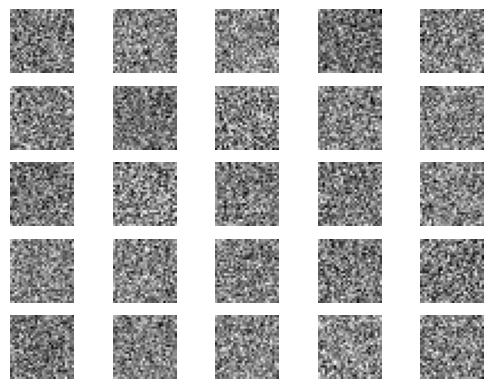

4/4 [==============================] - 0s 8ms/step
1 [D loss: 0.389931, acc.: 78.52%] [G loss: 0.857159]
4/4 [==============================] - 0s 7ms/step
2 [D loss: 0.344921, acc.: 82.81%] [G loss: 0.870432]
4/4 [==============================] - 0s 8ms/step
3 [D loss: 0.319455, acc.: 90.62%] [G loss: 0.883157]
4/4 [==============================] - 0s 7ms/step
4 [D loss: 0.303678, acc.: 90.62%] [G loss: 0.969245]
4/4 [==============================] - 0s 9ms/step
5 [D loss: 0.275221, acc.: 94.53%] [G loss: 1.049405]
4/4 [==============================] - 0s 9ms/step
6 [D loss: 0.246916, acc.: 97.27%] [G loss: 1.172899]
4/4 [==============================] - 0s 9ms/step
7 [D loss: 0.213987, acc.: 99.61%] [G loss: 1.309242]
4/4 [==============================] - 0s 11ms/step
8 [D loss: 0.186982, acc.: 100.00%] [G loss: 1.431910]
4/4 [==============================] - 0s 10ms/step
9 [D loss: 0.153474, acc.: 100.00%] [G loss: 1.582196]
4/4 [==============================] - 0s 10ms/step

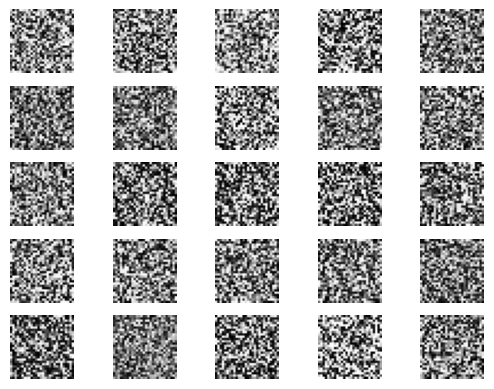

4/4 [==============================] - 0s 8ms/step
51 [D loss: 0.019147, acc.: 100.00%] [G loss: 3.708592]
4/4 [==============================] - 0s 14ms/step
52 [D loss: 0.022688, acc.: 100.00%] [G loss: 3.696908]
4/4 [==============================] - 0s 10ms/step
53 [D loss: 0.027628, acc.: 100.00%] [G loss: 3.746503]
4/4 [==============================] - 0s 11ms/step
54 [D loss: 0.022121, acc.: 100.00%] [G loss: 3.752711]
4/4 [==============================] - 0s 7ms/step
55 [D loss: 0.022960, acc.: 100.00%] [G loss: 3.850443]
4/4 [==============================] - 0s 9ms/step
56 [D loss: 0.019175, acc.: 100.00%] [G loss: 3.841923]
4/4 [==============================] - 0s 8ms/step
57 [D loss: 0.023440, acc.: 100.00%] [G loss: 3.802855]
4/4 [==============================] - 0s 9ms/step
58 [D loss: 0.019546, acc.: 100.00%] [G loss: 3.847270]
4/4 [==============================] - 0s 12ms/step
59 [D loss: 0.021719, acc.: 100.00%] [G loss: 3.901572]
4/4 [============================

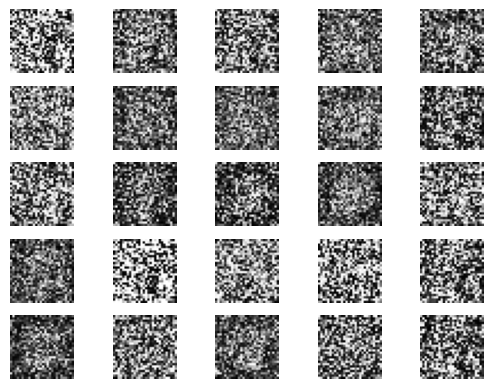

4/4 [==============================] - 0s 9ms/step
101 [D loss: 0.104355, acc.: 98.44%] [G loss: 3.249897]
4/4 [==============================] - 0s 9ms/step
102 [D loss: 0.077940, acc.: 98.44%] [G loss: 3.647218]
4/4 [==============================] - 0s 8ms/step
103 [D loss: 0.144625, acc.: 94.92%] [G loss: 3.538715]
4/4 [==============================] - 0s 8ms/step
104 [D loss: 0.147468, acc.: 94.92%] [G loss: 3.864208]
4/4 [==============================] - 0s 8ms/step
105 [D loss: 0.947208, acc.: 67.19%] [G loss: 2.058255]
4/4 [==============================] - 0s 7ms/step
106 [D loss: 0.552389, acc.: 76.95%] [G loss: 2.300997]
4/4 [==============================] - 0s 9ms/step
107 [D loss: 0.159933, acc.: 91.80%] [G loss: 3.328268]
4/4 [==============================] - 0s 8ms/step
108 [D loss: 0.063420, acc.: 98.44%] [G loss: 3.718301]
4/4 [==============================] - 0s 9ms/step
109 [D loss: 0.064150, acc.: 99.22%] [G loss: 3.774665]
4/4 [==============================] 

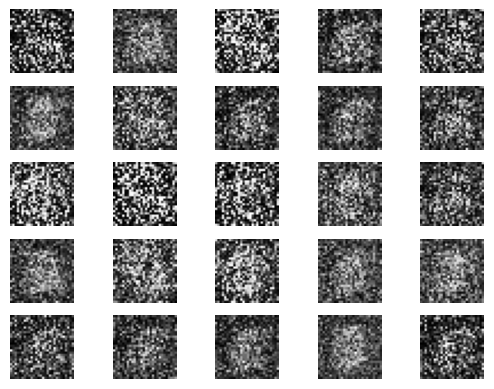

4/4 [==============================] - 0s 8ms/step
151 [D loss: 0.285211, acc.: 86.33%] [G loss: 2.979519]
4/4 [==============================] - 0s 9ms/step
152 [D loss: 0.329065, acc.: 87.50%] [G loss: 2.342682]
4/4 [==============================] - 0s 8ms/step
153 [D loss: 0.310537, acc.: 82.81%] [G loss: 3.115077]
4/4 [==============================] - 0s 8ms/step
154 [D loss: 0.743903, acc.: 59.77%] [G loss: 1.630796]
4/4 [==============================] - 0s 8ms/step
155 [D loss: 0.222440, acc.: 89.45%] [G loss: 3.054829]
4/4 [==============================] - 0s 8ms/step
156 [D loss: 0.371795, acc.: 82.03%] [G loss: 2.603576]
4/4 [==============================] - 0s 10ms/step
157 [D loss: 0.323337, acc.: 83.20%] [G loss: 2.665607]
4/4 [==============================] - 0s 8ms/step
158 [D loss: 0.428239, acc.: 77.73%] [G loss: 2.577355]
4/4 [==============================] - 0s 9ms/step
159 [D loss: 0.393748, acc.: 77.73%] [G loss: 2.436308]
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step
201 [D loss: 0.668651, acc.: 46.48%] [G loss: 1.222806]
4/4 [==============================] - 0s 8ms/step
202 [D loss: 0.704680, acc.: 44.14%] [G loss: 1.083221]
4/4 [==============================] - 0s 9ms/step
203 [D loss: 0.707400, acc.: 50.00%] [G loss: 0.981587]
4/4 [==============================] - 0s 11ms/step
204 [D loss: 0.662809, acc.: 46.88%] [G loss: 1.084750]
4/4 [==============================] - 0s 8ms/step
205 [D loss: 0.742404, acc.: 42.97%] [G loss: 0.869210]
4/4 [==============================] - 0s 9ms/step
206 [D loss: 0.713642, acc.: 45.70%] [G loss: 0.854192]
4/4 [==============================] - 0s 8ms/step
207 [D loss: 0.696353, acc.: 46.88%] [G loss: 0.957375]
4/4 [==============================] - 0s 9ms/step
208 [D loss: 0.784979, acc.: 38.67%] [G loss: 0.768233]
4/4 [==============================] - 0s 9ms/step
209 [D loss: 0.671063, acc.: 46.88%] [G loss: 0.868936]
4/4 [==============================]

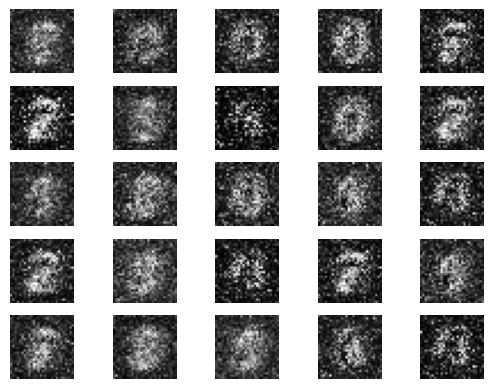

4/4 [==============================] - 0s 9ms/step
251 [D loss: 0.681436, acc.: 44.53%] [G loss: 0.622423]
4/4 [==============================] - 0s 10ms/step
252 [D loss: 0.667140, acc.: 48.44%] [G loss: 0.627173]
4/4 [==============================] - 0s 9ms/step
253 [D loss: 0.666318, acc.: 48.44%] [G loss: 0.623865]
4/4 [==============================] - 0s 10ms/step
254 [D loss: 0.685321, acc.: 46.48%] [G loss: 0.616292]
4/4 [==============================] - 0s 8ms/step
255 [D loss: 0.679621, acc.: 47.66%] [G loss: 0.615405]
4/4 [==============================] - 0s 9ms/step
256 [D loss: 0.667365, acc.: 47.66%] [G loss: 0.625539]
4/4 [==============================] - 0s 9ms/step
257 [D loss: 0.674845, acc.: 46.48%] [G loss: 0.619661]
4/4 [==============================] - 0s 9ms/step
258 [D loss: 0.676311, acc.: 46.88%] [G loss: 0.616297]
4/4 [==============================] - 0s 10ms/step
259 [D loss: 0.679440, acc.: 45.70%] [G loss: 0.615469]
4/4 [=============================

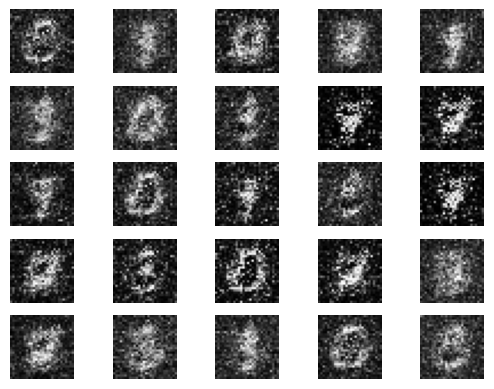

4/4 [==============================] - 0s 9ms/step
301 [D loss: 0.671410, acc.: 48.83%] [G loss: 0.638394]
4/4 [==============================] - 0s 13ms/step
302 [D loss: 0.653001, acc.: 48.05%] [G loss: 0.635150]
4/4 [==============================] - 0s 11ms/step
303 [D loss: 0.653429, acc.: 49.61%] [G loss: 0.626341]
4/4 [==============================] - 0s 11ms/step
304 [D loss: 0.661784, acc.: 49.22%] [G loss: 0.627531]
4/4 [==============================] - 0s 9ms/step
305 [D loss: 0.667440, acc.: 48.44%] [G loss: 0.624544]
4/4 [==============================] - 0s 9ms/step
306 [D loss: 0.658435, acc.: 50.00%] [G loss: 0.621644]
4/4 [==============================] - 0s 12ms/step
307 [D loss: 0.658544, acc.: 50.00%] [G loss: 0.626454]
4/4 [==============================] - 0s 8ms/step
308 [D loss: 0.669718, acc.: 47.66%] [G loss: 0.627482]
4/4 [==============================] - 0s 11ms/step
309 [D loss: 0.659436, acc.: 49.22%] [G loss: 0.632591]
4/4 [===========================

4/4 [==============================] - 0s 9ms/step
351 [D loss: 0.622614, acc.: 50.39%] [G loss: 0.667390]
4/4 [==============================] - 0s 14ms/step
352 [D loss: 0.631005, acc.: 49.61%] [G loss: 0.672845]
4/4 [==============================] - 0s 10ms/step
353 [D loss: 0.630661, acc.: 48.83%] [G loss: 0.674400]
4/4 [==============================] - 0s 9ms/step
354 [D loss: 0.638505, acc.: 49.22%] [G loss: 0.673131]
4/4 [==============================] - 0s 10ms/step
355 [D loss: 0.631883, acc.: 49.61%] [G loss: 0.669941]
4/4 [==============================] - 0s 9ms/step
356 [D loss: 0.627958, acc.: 50.00%] [G loss: 0.667914]
4/4 [==============================] - 0s 14ms/step
357 [D loss: 0.645776, acc.: 49.61%] [G loss: 0.667000]
4/4 [==============================] - 0s 10ms/step
358 [D loss: 0.627528, acc.: 50.00%] [G loss: 0.659929]
4/4 [==============================] - 0s 9ms/step
359 [D loss: 0.641319, acc.: 49.22%] [G loss: 0.658656]
4/4 [===========================

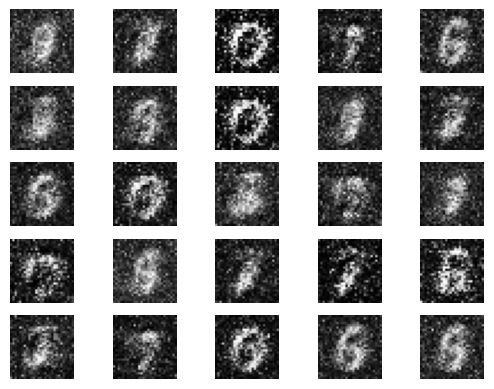

4/4 [==============================] - 0s 11ms/step
401 [D loss: 0.634138, acc.: 49.22%] [G loss: 0.689934]
4/4 [==============================] - 0s 8ms/step
402 [D loss: 0.636309, acc.: 51.17%] [G loss: 0.694250]
4/4 [==============================] - 0s 9ms/step
403 [D loss: 0.635760, acc.: 50.78%] [G loss: 0.704477]
4/4 [==============================] - 0s 11ms/step
404 [D loss: 0.633383, acc.: 49.22%] [G loss: 0.703035]
4/4 [==============================] - 0s 10ms/step
405 [D loss: 0.625091, acc.: 48.83%] [G loss: 0.702644]
4/4 [==============================] - 0s 10ms/step
406 [D loss: 0.629989, acc.: 50.78%] [G loss: 0.699427]
4/4 [==============================] - 0s 9ms/step
407 [D loss: 0.631010, acc.: 49.22%] [G loss: 0.698064]
4/4 [==============================] - 0s 10ms/step
408 [D loss: 0.638196, acc.: 48.83%] [G loss: 0.698907]
4/4 [==============================] - 0s 9ms/step
409 [D loss: 0.635894, acc.: 50.78%] [G loss: 0.693025]
4/4 [===========================

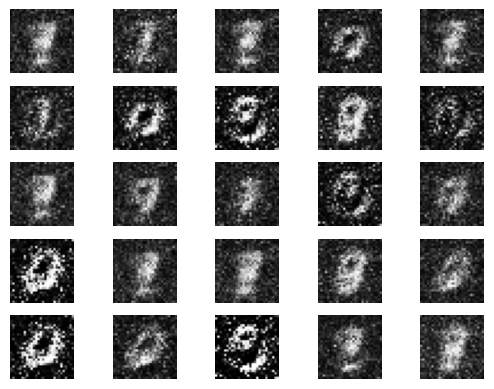

4/4 [==============================] - 0s 9ms/step
451 [D loss: 0.658884, acc.: 51.56%] [G loss: 0.676236]
4/4 [==============================] - 0s 9ms/step
452 [D loss: 0.658986, acc.: 51.95%] [G loss: 0.676042]
4/4 [==============================] - 0s 9ms/step
453 [D loss: 0.662681, acc.: 53.52%] [G loss: 0.691238]
4/4 [==============================] - 0s 9ms/step
454 [D loss: 0.657733, acc.: 52.73%] [G loss: 0.695732]
4/4 [==============================] - 0s 10ms/step
455 [D loss: 0.662001, acc.: 54.30%] [G loss: 0.699359]
4/4 [==============================] - 0s 11ms/step
456 [D loss: 0.653991, acc.: 55.86%] [G loss: 0.690441]
4/4 [==============================] - 0s 8ms/step
457 [D loss: 0.652996, acc.: 53.12%] [G loss: 0.691707]
4/4 [==============================] - 0s 11ms/step
458 [D loss: 0.646907, acc.: 56.25%] [G loss: 0.691274]
4/4 [==============================] - 0s 8ms/step
459 [D loss: 0.653610, acc.: 53.91%] [G loss: 0.693330]
4/4 [=============================

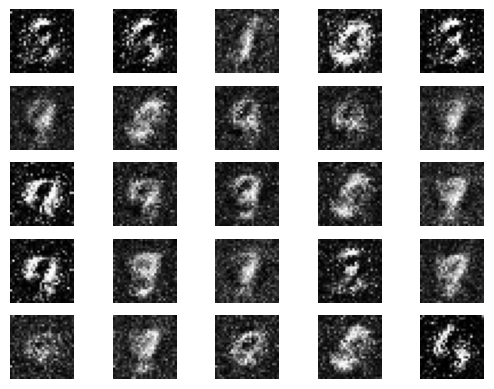

4/4 [==============================] - 0s 9ms/step
501 [D loss: 0.640170, acc.: 55.08%] [G loss: 0.718026]
4/4 [==============================] - 0s 9ms/step
502 [D loss: 0.644416, acc.: 54.30%] [G loss: 0.724755]
4/4 [==============================] - 0s 9ms/step
503 [D loss: 0.636190, acc.: 57.03%] [G loss: 0.730088]
4/4 [==============================] - 0s 9ms/step
504 [D loss: 0.645523, acc.: 53.12%] [G loss: 0.721094]
4/4 [==============================] - 0s 10ms/step
505 [D loss: 0.641017, acc.: 53.91%] [G loss: 0.707966]
4/4 [==============================] - 0s 11ms/step
506 [D loss: 0.645920, acc.: 50.78%] [G loss: 0.704491]
4/4 [==============================] - 0s 9ms/step
507 [D loss: 0.645054, acc.: 51.95%] [G loss: 0.703769]
4/4 [==============================] - 0s 10ms/step
508 [D loss: 0.634886, acc.: 54.69%] [G loss: 0.702912]
4/4 [==============================] - 0s 9ms/step
509 [D loss: 0.629708, acc.: 57.81%] [G loss: 0.698515]
4/4 [=============================

4/4 [==============================] - 0s 10ms/step
551 [D loss: 0.610320, acc.: 63.67%] [G loss: 0.740933]
4/4 [==============================] - 0s 10ms/step
552 [D loss: 0.597871, acc.: 64.84%] [G loss: 0.730161]
4/4 [==============================] - 0s 9ms/step
553 [D loss: 0.605888, acc.: 65.62%] [G loss: 0.728161]
4/4 [==============================] - 0s 10ms/step
554 [D loss: 0.612392, acc.: 66.02%] [G loss: 0.735537]
4/4 [==============================] - 0s 9ms/step
555 [D loss: 0.616903, acc.: 62.89%] [G loss: 0.734413]
4/4 [==============================] - 0s 10ms/step
556 [D loss: 0.629473, acc.: 62.50%] [G loss: 0.740911]
4/4 [==============================] - 0s 10ms/step
557 [D loss: 0.615359, acc.: 69.14%] [G loss: 0.767086]
4/4 [==============================] - 0s 9ms/step
558 [D loss: 0.607484, acc.: 67.58%] [G loss: 0.764073]
4/4 [==============================] - 0s 9ms/step
559 [D loss: 0.623984, acc.: 63.67%] [G loss: 0.762906]
4/4 [===========================

4/4 [==============================] - 0s 9ms/step
601 [D loss: 0.649514, acc.: 60.16%] [G loss: 0.780164]
4/4 [==============================] - 0s 10ms/step
602 [D loss: 0.645682, acc.: 58.20%] [G loss: 0.772575]
4/4 [==============================] - 0s 9ms/step
603 [D loss: 0.634246, acc.: 60.94%] [G loss: 0.758656]
4/4 [==============================] - 0s 9ms/step
604 [D loss: 0.656773, acc.: 60.94%] [G loss: 0.777945]
4/4 [==============================] - 0s 8ms/step
605 [D loss: 0.637208, acc.: 60.94%] [G loss: 0.806817]
4/4 [==============================] - 0s 8ms/step
606 [D loss: 0.619661, acc.: 65.62%] [G loss: 0.818452]
4/4 [==============================] - 0s 8ms/step
607 [D loss: 0.637803, acc.: 60.16%] [G loss: 0.812292]
4/4 [==============================] - 0s 10ms/step
608 [D loss: 0.633587, acc.: 59.77%] [G loss: 0.796136]
4/4 [==============================] - 0s 9ms/step
609 [D loss: 0.645879, acc.: 52.73%] [G loss: 0.776739]
4/4 [==============================

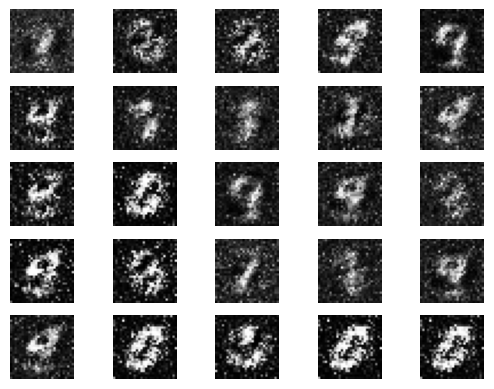

4/4 [==============================] - 0s 8ms/step
651 [D loss: 0.604889, acc.: 68.75%] [G loss: 0.808820]
4/4 [==============================] - 0s 10ms/step
652 [D loss: 0.612587, acc.: 61.72%] [G loss: 0.837724]
4/4 [==============================] - 0s 8ms/step
653 [D loss: 0.620215, acc.: 65.23%] [G loss: 0.846931]
4/4 [==============================] - 0s 9ms/step
654 [D loss: 0.609041, acc.: 67.19%] [G loss: 0.844103]
4/4 [==============================] - 0s 9ms/step
655 [D loss: 0.610958, acc.: 67.97%] [G loss: 0.831239]
4/4 [==============================] - 0s 10ms/step
656 [D loss: 0.621277, acc.: 64.84%] [G loss: 0.823344]
4/4 [==============================] - 0s 11ms/step
657 [D loss: 0.619282, acc.: 59.38%] [G loss: 0.833065]
4/4 [==============================] - 0s 9ms/step
658 [D loss: 0.605307, acc.: 67.97%] [G loss: 0.852408]
4/4 [==============================] - 0s 11ms/step
659 [D loss: 0.591284, acc.: 79.30%] [G loss: 0.851087]
4/4 [============================

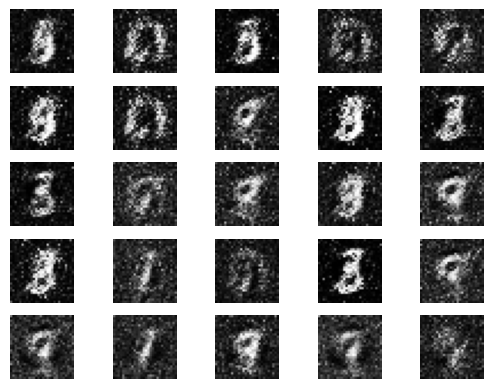

4/4 [==============================] - 0s 11ms/step
701 [D loss: 0.581855, acc.: 80.08%] [G loss: 0.881581]
4/4 [==============================] - 0s 8ms/step
702 [D loss: 0.591018, acc.: 74.61%] [G loss: 0.879597]
4/4 [==============================] - 0s 9ms/step
703 [D loss: 0.603093, acc.: 66.80%] [G loss: 0.879574]
4/4 [==============================] - 0s 10ms/step
704 [D loss: 0.586045, acc.: 77.34%] [G loss: 0.884965]
4/4 [==============================] - 0s 8ms/step
705 [D loss: 0.606206, acc.: 74.61%] [G loss: 0.855393]
4/4 [==============================] - 0s 9ms/step
706 [D loss: 0.605016, acc.: 70.31%] [G loss: 0.842559]
4/4 [==============================] - 0s 10ms/step
707 [D loss: 0.593091, acc.: 69.53%] [G loss: 0.858605]
4/4 [==============================] - 0s 11ms/step
708 [D loss: 0.615112, acc.: 69.14%] [G loss: 0.857843]
4/4 [==============================] - 0s 12ms/step
709 [D loss: 0.608695, acc.: 69.53%] [G loss: 0.856376]
4/4 [===========================

4/4 [==============================] - 0s 9ms/step
751 [D loss: 0.624992, acc.: 64.06%] [G loss: 0.873258]
4/4 [==============================] - 0s 8ms/step
752 [D loss: 0.594146, acc.: 68.75%] [G loss: 0.877142]
4/4 [==============================] - 0s 9ms/step
753 [D loss: 0.595908, acc.: 71.09%] [G loss: 0.890236]
4/4 [==============================] - 0s 9ms/step
754 [D loss: 0.597761, acc.: 71.48%] [G loss: 0.892338]
4/4 [==============================] - 0s 9ms/step
755 [D loss: 0.583158, acc.: 73.44%] [G loss: 0.864862]
4/4 [==============================] - 0s 13ms/step
756 [D loss: 0.600027, acc.: 73.83%] [G loss: 0.881096]
4/4 [==============================] - 0s 9ms/step
757 [D loss: 0.594863, acc.: 70.70%] [G loss: 0.874652]
4/4 [==============================] - 0s 9ms/step
758 [D loss: 0.590458, acc.: 72.66%] [G loss: 0.882977]
4/4 [==============================] - 0s 14ms/step
759 [D loss: 0.597885, acc.: 69.92%] [G loss: 0.883661]
4/4 [==============================

4/4 [==============================] - 0s 12ms/step
801 [D loss: 0.613506, acc.: 66.02%] [G loss: 0.864572]
4/4 [==============================] - 0s 10ms/step
802 [D loss: 0.579315, acc.: 73.44%] [G loss: 0.855396]
4/4 [==============================] - 0s 13ms/step
803 [D loss: 0.603866, acc.: 69.53%] [G loss: 0.873260]
4/4 [==============================] - 0s 21ms/step
804 [D loss: 0.596692, acc.: 73.83%] [G loss: 0.867138]
4/4 [==============================] - 0s 8ms/step
805 [D loss: 0.605823, acc.: 73.44%] [G loss: 0.882977]
4/4 [==============================] - 0s 18ms/step
806 [D loss: 0.609524, acc.: 68.36%] [G loss: 0.855217]
4/4 [==============================] - 0s 9ms/step
807 [D loss: 0.607588, acc.: 72.66%] [G loss: 0.858454]
4/4 [==============================] - 0s 9ms/step
808 [D loss: 0.629307, acc.: 66.80%] [G loss: 0.814347]
4/4 [==============================] - 0s 16ms/step
809 [D loss: 0.609193, acc.: 67.58%] [G loss: 0.853660]
4/4 [==========================

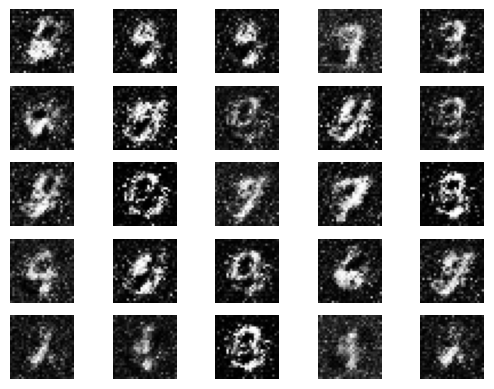

4/4 [==============================] - 0s 9ms/step
851 [D loss: 0.600583, acc.: 72.66%] [G loss: 0.863278]
4/4 [==============================] - 0s 15ms/step
852 [D loss: 0.636314, acc.: 67.19%] [G loss: 0.848569]
4/4 [==============================] - 0s 11ms/step
853 [D loss: 0.635620, acc.: 60.55%] [G loss: 0.870106]
4/4 [==============================] - 0s 11ms/step
854 [D loss: 0.611933, acc.: 67.58%] [G loss: 0.910397]
4/4 [==============================] - 0s 11ms/step
855 [D loss: 0.585907, acc.: 75.00%] [G loss: 0.940548]
4/4 [==============================] - 0s 9ms/step
856 [D loss: 0.581382, acc.: 76.56%] [G loss: 0.946350]
4/4 [==============================] - 0s 13ms/step
857 [D loss: 0.584668, acc.: 76.95%] [G loss: 0.954880]
4/4 [==============================] - 0s 14ms/step
858 [D loss: 0.585667, acc.: 78.12%] [G loss: 0.968176]
4/4 [==============================] - 0s 9ms/step
859 [D loss: 0.592464, acc.: 79.69%] [G loss: 0.909789]
4/4 [==========================

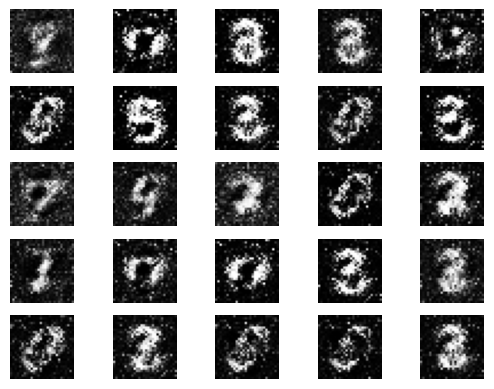

4/4 [==============================] - 0s 10ms/step
901 [D loss: 0.596102, acc.: 69.92%] [G loss: 0.900144]
4/4 [==============================] - 0s 8ms/step
902 [D loss: 0.571205, acc.: 77.34%] [G loss: 0.908359]
4/4 [==============================] - 0s 9ms/step
903 [D loss: 0.601234, acc.: 71.88%] [G loss: 0.924528]
4/4 [==============================] - 0s 8ms/step
904 [D loss: 0.566781, acc.: 72.66%] [G loss: 0.923859]
4/4 [==============================] - 0s 8ms/step
905 [D loss: 0.611730, acc.: 65.23%] [G loss: 0.907270]
4/4 [==============================] - 0s 10ms/step
906 [D loss: 0.590726, acc.: 69.92%] [G loss: 0.892649]
4/4 [==============================] - 0s 9ms/step
907 [D loss: 0.575361, acc.: 77.73%] [G loss: 0.905392]
4/4 [==============================] - 0s 8ms/step
908 [D loss: 0.618383, acc.: 64.84%] [G loss: 0.903887]
4/4 [==============================] - 0s 9ms/step
909 [D loss: 0.606185, acc.: 69.14%] [G loss: 0.896324]
4/4 [==============================

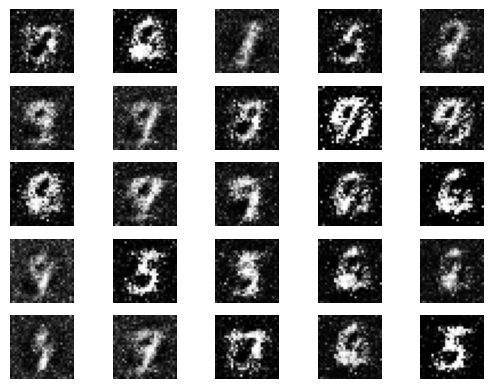

4/4 [==============================] - 0s 9ms/step
951 [D loss: 0.561704, acc.: 76.95%] [G loss: 0.976439]
4/4 [==============================] - 0s 9ms/step
952 [D loss: 0.594204, acc.: 72.27%] [G loss: 0.929432]
4/4 [==============================] - 0s 8ms/step
953 [D loss: 0.566438, acc.: 80.86%] [G loss: 0.936825]
4/4 [==============================] - 0s 8ms/step
954 [D loss: 0.571295, acc.: 79.69%] [G loss: 0.934998]
4/4 [==============================] - 0s 10ms/step
955 [D loss: 0.565034, acc.: 80.47%] [G loss: 0.953032]
4/4 [==============================] - 0s 10ms/step
956 [D loss: 0.580877, acc.: 76.17%] [G loss: 0.951737]
4/4 [==============================] - 0s 9ms/step
957 [D loss: 0.540837, acc.: 86.33%] [G loss: 1.004303]
4/4 [==============================] - 0s 10ms/step
958 [D loss: 0.576394, acc.: 78.91%] [G loss: 0.975368]
4/4 [==============================] - 0s 11ms/step
959 [D loss: 0.580110, acc.: 76.17%] [G loss: 0.969606]
4/4 [============================

In [ ]:
gan = GAN()

gan.train(epochs=1000, batch_size=128, sample_interval=50)